# <center> Обучение с учителем. Классификация. Практика

## <center> Прогнозирование оттока клиентов банка

## Постановка задачи

### Постановка задачи:

Некоторый банк обратился к вам за помощью: он хочет разработать кампанию лояльности по удержанию клиентов. Для этого он хочет прогнозировать вероятности оттока клиентов и определять, уйдёт ли клиент в ближайшее время.

В этой связи необходимо построить классификатор, который позволит своевременно определять уходящих клиентов банка, оценить качество построенных моделей и проинтерпретировать результаты.

### Разделим эту задачу на две части:

* В первой части мы подготовим данные для моделирования и построим простейшую модель логистической регрессии, оценим её качество и проанализируем результаты её работы.

* Во второй части мы займёмся построением моделей дерева решений и случайного леса, сравним их результаты с результатами, полученными на первом этапе, и сделаем финальный вывод.

---

### Знакомство с данными:

1. RowNumber — номер строки таблицы;
2. CustomerId — идентификатор клиента;
3. Surname — фамилия клиента;
4. CreditScore — кредитный рейтинг клиента (чем он выше, тем больше клиент брал кредитов и возвращал их);
5. Geography — страна проживания клиента (банк межнациональный);
6. Gender — пол клиента;
7. Age — возраст клиента;
8. Tenure — сколько лет клиент пользуется банком;
9. Balance — сколько у клиента денег на счетах в банке;
10. NumOfProduct — число услуг банка, которыми воспользовался клиент;
11. HasCrCard — есть ли у клиента кредитная карта (1 — да, 0 — нет);
12. IsActiveMember — есть ли у клиента статус «активный клиент» (1 — да, 0 — нет);
13. EstimatedSalary — предполагаемая заработная плата клиента;
14. Exited — статус ушедшего (1 — ушедший клиент, 0 — лояльный клиент).

### Импорт необходимых библиотек:

In [2]:
import numpy as np # для матричных вычислений
import pandas as pd # для анализа и предобработки данных
import matplotlib.pyplot as plt # для визуализации
import seaborn as sns # для визуализации

from sklearn import model_selection # сплитование выборки
from sklearn.preprocessing import RobustScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
%matplotlib inline

Прочитаем первые и последние пять строк нашего датасета

In [3]:
# Чтение CSV-файла с данными о оттоке клиентов
churn_data = pd.read_csv('data/churn.csv')

# Вывод первых 5 строк данных
display(churn_data.head(5))

# Вывод последних 5 строк данных
display(churn_data.tail(5))

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1
9999,10000,15628319,Walker,792,France,Female,28,4,130142.79,1,1,0,38190.78,0


## Практика: логистическая регрессия

В первой части вам предстоит выполнить задания 5.0–5.6. Максимальное количество баллов, которое можно получить, — 9:

### Задание 5.0 (не оценивается)

Для полноты задачи проведите небольшой разведывательный анализ данных. Постройте графики распределения целевого признака, диаграммы и графики, показывающие взаимосвязь между исходными признаками и целевым признаком, а также другие диаграммы, иллюстрирующие предоставленные данные. 

**Совет:** воспользуйтесь кодом, который вы писали, выполняя задания в модуле «PYTHON-13. Визуализация данных».

In [4]:
# Копируем датасет для последующей обработки
churn_data_copy = churn_data.copy()

# Выделяем отдельно категориальные и числовые признаки
num_features = churn_data_copy.select_dtypes(include=['int64', 'float64']).columns
cat_features = churn_data_copy.select_dtypes(include=['object']).columns

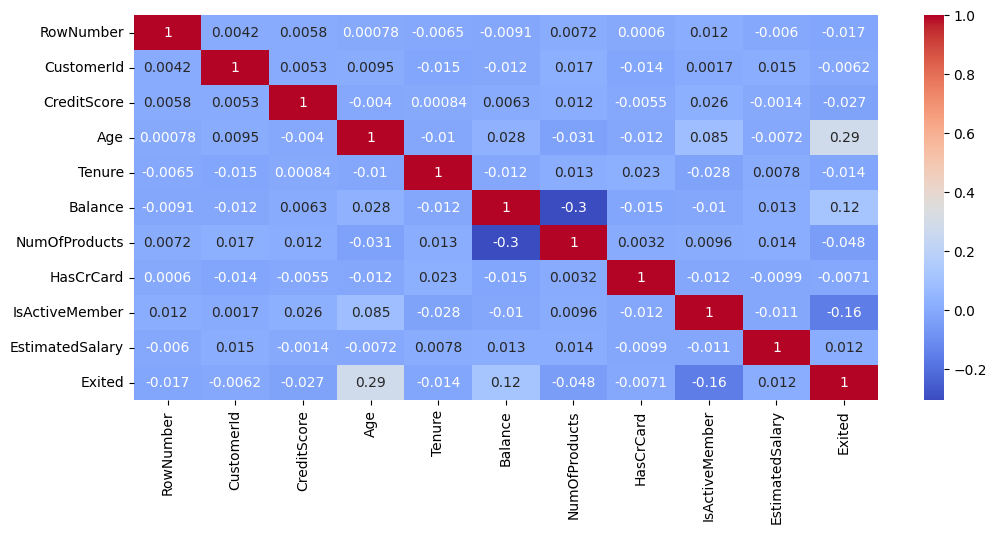

In [5]:
# Создаём фигуру для графика и устанавливаем размер 12x5 дюймов
fig = plt.figure(figsize=(12, 5))

# Строим тепловую карту (heatmap) корреляций между числовыми признаками в датасете
# insurance_data_copy.corr() вычисляет матрицу корреляций между числовыми столбцами
# Параметр annot=True добавляет значения корреляции на график в виде аннотаций
sns.heatmap(churn_data_copy[num_features].corr(), cmap="coolwarm", annot=True);

Поскольку графиков достаточно много и на их отрисовку уходит много времени мы не будем выводить всю информацию, т.к. в этом нет необходимости. Выборка составляет 60 % от основной массы.

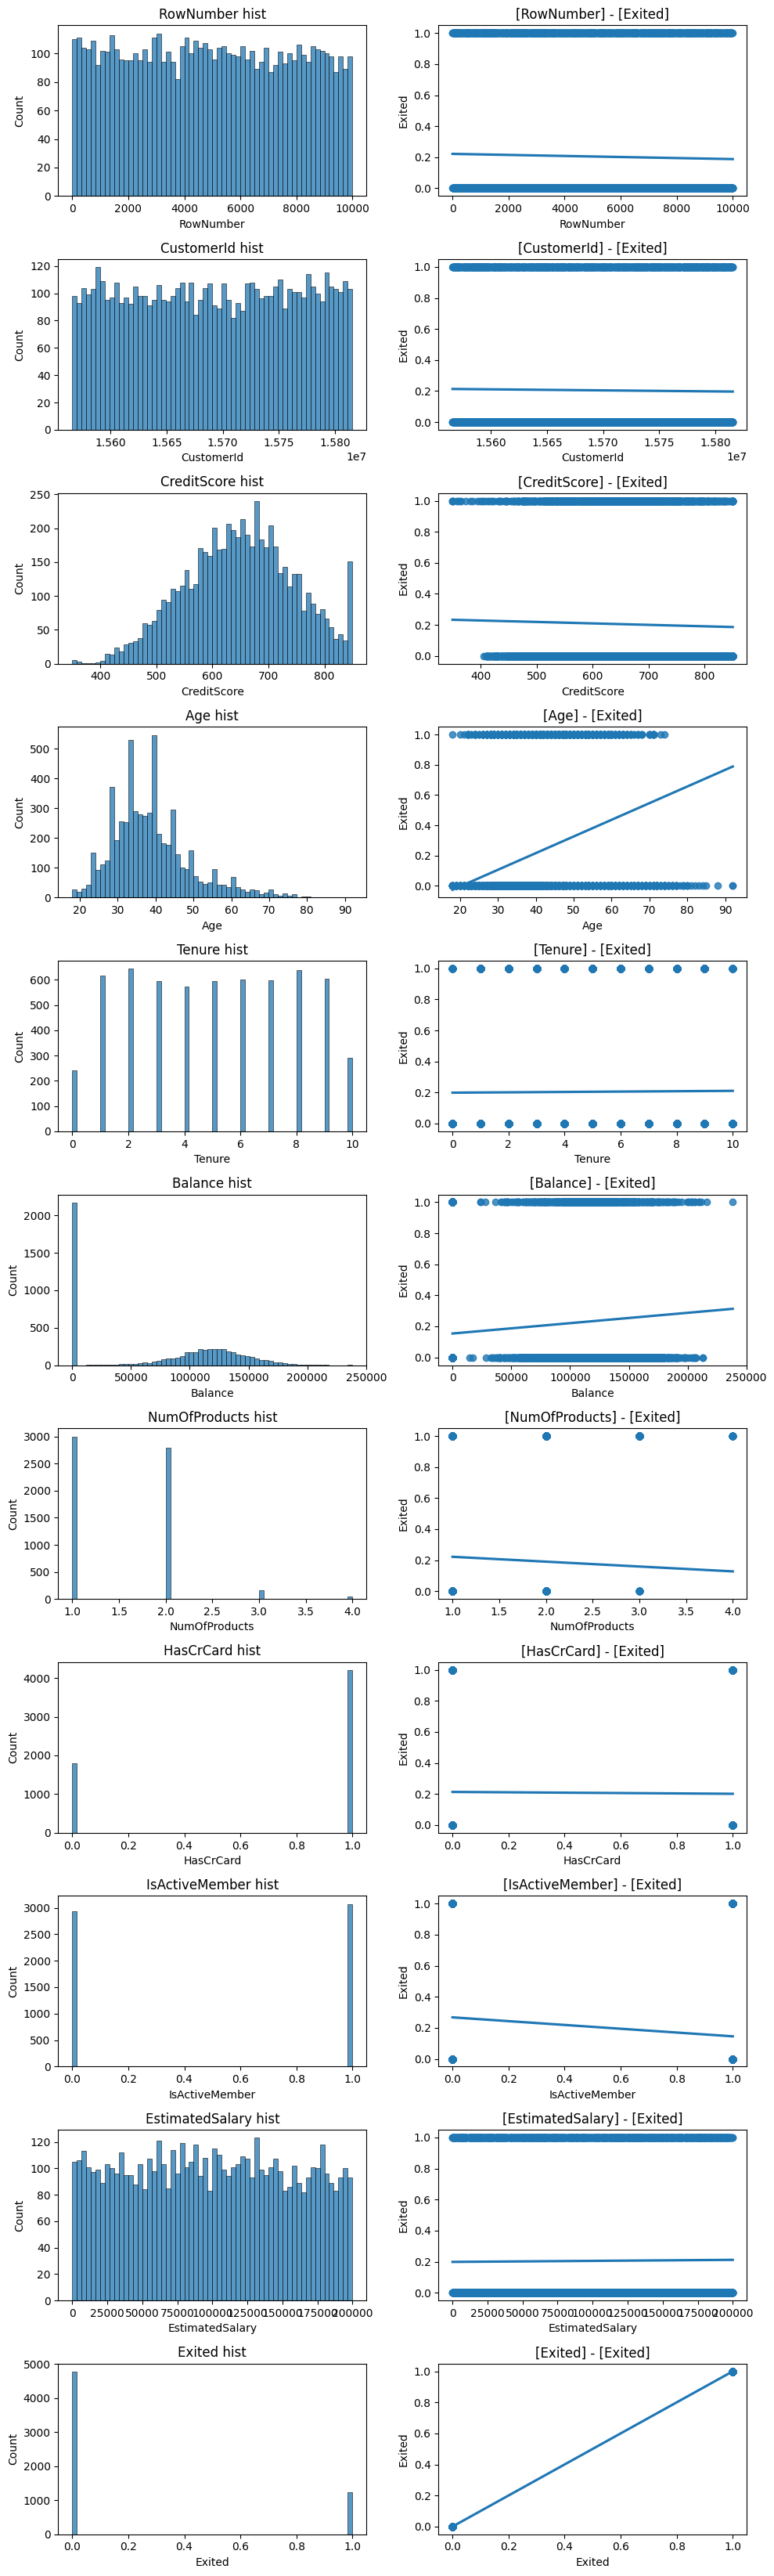

In [6]:
# Используем 60% данных для построения графиков
churn_size = int(len(churn_data_copy) * 0.6)
churn_data = churn_data_copy.sample(n=churn_size, random_state=42)

# Количество числовых признаков
num_of_rows = len(num_features)

# Создаем фигуру и набор осей
fig, axes = plt.subplots(num_of_rows, 2, figsize=(10, num_of_rows * 3))  # Динамическое изменение высоты

# Основные числовые признаки
for i, feature in enumerate(num_features):
    # Строим гистограмму распределения признака
    sns.histplot(data=churn_data, x=feature, bins=60, ax=axes[i][0]).set_title(f'{feature} hist')
    
    # Строим диаграмму рассеяния и линию регрессии
    sns.regplot(data=churn_data, x=feature, y='Exited', ci=None, ax=axes[i][1]).set_title(f'[{feature}] - [Exited]')

# Плотная компоновка и отображение графиков
plt.tight_layout()
plt.show()

В модуле по визуализации мы выяснили, что отток в Германии, Франции и Испании имеет различные показатели. Исследователи, которые уже работали с этим датасетом, пришли к выводу, что наилучшее решение при работе с этими данными — строить модели индивидуально для каждой страны. Мы будем прогнозировать отток в немецком филиале банка. Давайте выделим только данные, относящиеся к Германии:

In [7]:
# Выборка только по немецкому филиалу
churn_data_copy = churn_data_copy[churn_data_copy['Geography'] == 'Germany']

display(churn_data_copy.shape)

(2509, 14)

Сразу избавимся от заведомо неинформативных признаков: страна, номер строки, идентификатор пользователя и имя клиента.

In [8]:
# Удаляем лишние неинформативные признаки
churn_data_copy = churn_data_copy.drop(['Geography', 'RowNumber', 'CustomerId', 'Surname'], axis=1)

display(churn_data_copy.head())

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
7,376,Female,29,4,115046.74,4,1,0,119346.88,1
15,616,Male,45,3,143129.41,2,0,1,64327.26,0
16,653,Male,58,1,132602.88,1,1,0,5097.67,1
26,756,Male,36,2,136815.64,1,1,1,170041.95,0
28,574,Female,43,3,141349.43,1,1,1,100187.43,0


Проверим, что в наших данных нет пропусков:

In [9]:
# Проверяем данные на пропуски
churn_data_copy.isnull().sum()

CreditScore        0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Проверим, что в наших данных нет дубликатов:

In [10]:
# Проверяем данные на дубликаты
churn_data_copy.duplicated().sum()

0

### Задание 5.1 (1 балл)

Давайте сделаем предобработку данных. 

Для начала расширим датасет с помощью методов Feature Engineering. Создайте следующие признаки:
* `BalanceSalaryRatio` — отношение баланса на счетах к заработной плате клиента;
* `TenureByAge` — отношение времени пользования услугами банка к возрасту клиента;
* `CreditScoreGivenAge` — отношение кредитного рейтинга к возрасту клиента.

Затем перекодируйте оставшиеся текстовые категориальные признаки в числовые бинарные столбцы.

Выведите основные статистические характеристики полученных признаков.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для создания указанных в задании признаков;
    * приведён код для кодирования категориальных признаков в числовые бинарные столбцы;
    * приведён код для расчёта основных статистических характеристик полученных признаков.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [11]:
# Расчет отношения баланса на счетах к предполагаемой заработной плате клиента
churn_data_copy['BalanceSalaryRatio'] = churn_data_copy['Balance'] / churn_data_copy['EstimatedSalary']
# Расчет отношения времени пользования услугами банка к возрасту клиента
churn_data_copy['TenureByAge'] = churn_data_copy['Tenure'] / churn_data_copy['Age']
# Расчет отношения кредитного рейтинга к возрасту клиента
churn_data_copy['CreditScoreGivenAge'] = churn_data_copy['CreditScore'] / churn_data_copy['Age']

# Кодирование оставшегося категориального признака
churn_data_copy = pd.get_dummies(churn_data_copy)

# Основные статистические характеристики
display(churn_data_copy.describe())

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge
count,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000,2509.00000,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000
mean,651.453567,39.771622,5.009964,119730.116134,1.519729,0.71383,0.497409,101113.435102,0.324432,9.024870,0.134303,17.526487
std,98.168937,10.519143,2.935154,27022.006157,0.619420,0.45206,0.500093,58263.011501,0.468256,214.286020,0.087680,5.349558
min,350.000000,18.000000,0.000000,27288.430000,1.000000,0.00000,0.000000,11.580000,0.000000,0.192582,0.000000,6.112676
25%,584.000000,32.000000,2.000000,102800.720000,1.000000,0.00000,0.000000,51016.020000,0.000000,0.783284,0.060606,13.686275
50%,651.000000,38.000000,5.000000,119703.100000,1.000000,1.00000,0.000000,102397.220000,0.000000,1.197220,0.125000,16.857143
75%,722.000000,45.000000,8.000000,137560.380000,2.000000,1.00000,1.000000,151083.800000,1.000000,2.400083,0.200000,20.852941
max,850.000000,84.000000,10.000000,214346.960000,4.000000,1.00000,1.000000,199970.740000,1.000000,10614.655440,0.500000,46.388889


Разделим исходный набор данных на матрицу наблюдений `X` (фичи) и столбец ответов `y` (таргет). 

In [12]:
# Создаем матрицу признаков X и столбец с ответами y
X = churn_data_copy.drop("Exited", axis=1)
y = churn_data_copy["Exited"]

Прежде чем перейти к этапу разделения выборки на тренировочную и тестовую, давайте посмотрим на сбалансированность данных. Для этого воспользуемся методом `value_counts()` и выведем количество наблюдений каждого из классов в долевом соотношении от общего количества наблюдений:

In [13]:
# Проверяем сбалансированность данных с помощью метода value_counts()
y.value_counts(normalize=True)

Exited
0    0.675568
1    0.324432
Name: proportion, dtype: float64

Очевидно, что классы не сбалансированы. Ушедших пользователей 32 %, в то время как лояльных — 68 % (если округлить).

**К чему это может привести?**

При разделении набора данных на тренировочный и тестовый может возникнуть такая ситуация, что в тренировочную выборку попадут только лояльные клиенты или их большая часть. Тогда модель может не научиться определять вероятность оттока и качество на тестовой выборке будет неудовлетворительным.

Или противоположная ситуация: в тестовую выборку попадут только лояльные клиенты. Тогда модель будет показывать отличное качество на тестовой выборке, но в реальных условиях она может оказаться бесполезной.

То есть нам нужно сделать так, чтобы в тренировочной и тестовой выборке было одинаковое соотношение лояльных и ушедших клиентов. Такое разбиение выборки называется **стратифицированным**. 

Функция `train_test_split()` из библиотеки `sklearn` умеет производить такое разбиение. Для этого в ней предусмотрен параметр `stratify`, который нужно выставить в значение признака, который должен иметь одинаковые соотношения в тренировочной и тестовой выборке. У нас этот признак - это целевой признак y. 

Выполним разбиение, установив значение параметра `random_state` на 0:


In [14]:
# Разделение данных на обучающую и тестовую выборки с использованием стратификации
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    stratify=y, 
    random_state=0
)

# Вывод формы обучающей и тестовой выборок
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1881, 13)
Test shape: (628, 13)


Проверим, что число лояльных и ушедших клиентов примерно одинаково в каждой из выборок:

In [15]:
# Вывод распределения целевой переменной в обучающей и тестовой выборках
print('Train :')
display(y_train.value_counts(normalize=True))
print()
print('Test :', )
display(y_test.value_counts(normalize=True))

churn_data_copy.isnull().sum()

Train :


Exited
0    0.675704
1    0.324296
Name: proportion, dtype: float64


Test :


Exited
0    0.675159
1    0.324841
Name: proportion, dtype: float64

CreditScore            0
Age                    0
Tenure                 0
Balance                0
NumOfProducts          0
HasCrCard              0
IsActiveMember         0
EstimatedSalary        0
Exited                 0
BalanceSalaryRatio     0
TenureByAge            0
CreditScoreGivenAge    0
Gender_Female          0
Gender_Male            0
dtype: int64

Соотношения одинаковы, а значит, мы можем перейти к следующему шагу.

### Задание 5.2 (1 балл)

Позаботьтесь о масштабировании признаков. Проведите нормализацию/стандартизацию матрицы наблюдений `X` с помощью `MinMaxScaler`/`RobustScaler` или `StandardScaler`. Выберите метод самостоятельно.

Обучите один из предложенных скейлеров на тренировочной выборке (вычислите параметры трансформации) и примените трансформацию данных к тренировочной и тестовой выборкам.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для создания одного из вариантов скейлеров для масштабирования данных;
    * приведён код для расчёта параметров трансформации (обучение скейлера) на тренировочной выборке;
    * приведён код для трансформации тренировочных и тестовых данных (признаков) в соответствии с вычисленными параметрами.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [16]:
# Масштабирование данных с помощью RobustScaler
robust_scaler = RobustScaler()

# Обучение скейлера на тренировочной выборке
X_train_scaled = robust_scaler.fit_transform(X_train)
# Применение трансформации к тестовой выборке
X_test_scaled = robust_scaler.transform(X_test)

# Вывод формы и типа данных
print('Train shape: {}'.format(X_train_scaled.shape))
print('Test shape: {}'.format(X_test_scaled.shape))

Train shape: (1881, 13)
Test shape: (628, 13)


Теперь переходим к моделированию.

### Задание 5.3 (1 балл)

Для начала давайте заранее определим метрику, на которую будем ориентироваться. 

По условию задачи, наша модель должна своевременно предсказывать отток клиентов. Известно, что для сохранения клиентов банк будет использовать ресурсы колл-центра и клиентам, у которых вероятность оттока наиболее высока, будут сделаны специальные предложения. Ресурсы, выделяемые на сохранение клиентов, ограничены, поэтому нам важно минимизировать количество звонков. Однако в то же время необходимо сохранить как можно больше клиентов.

Таким образом, нам бы хотелось минимизировать как ложноположительные и ложноотрицательные срабатывания модели.

Какую метрику в данной задаче вы будете пытаться улучшить? Обоснуйте свой выбор.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * выбрана верная метрика;
    * приведено развернутое обоснование выбора метрики, и приведенные рассуждения являются верными;

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

Чтобы минимизировать, как ложнотрицательные, так и ложноположительные срабатывания модели можно использовать метрику F1-мера, которая сочетает в себе точность (Precision) и полноту (Recall). F1-мера объединяет Precision и Recall в одну метрику, что делает ее идеальной в ситуациях, когда важно учитывать оба показателя. Рассчитывается как среднее гармоническое между Precision и Recall, т.е баланс между обоими показателями.

### Задание 5.4 (2 балла)

Обучите модель логистической регрессии (`Logistic Regression`) на тренировочных данных. Позаботьтесь о воспроизводимости результата, установив конкретное значение параметра `random_state` (например, число 42).

Сделайте предсказание меток классов для тренировочной и тестовой выборок. 

Рассчитайте значение целевой метрики на тренировочной и тестовой выборках. 

Проинтерпретируйте полученные результаты, ответив на следующий вопрос:
* Как вы считаете, является ли ваша модель переобученной или недообученной?

> **Примечание.** Будем считать, что модель нас не удовлетворяет (считается недообученной), если значение целевой метрики на тестовой выборке меньше 0.5.

**Дополнительное задание:**

Попробуйте поуправлять следующими параметрами модели:
* `penalty` — тип используемой регуляризации ('l1' — $L_1$-регуляризация, 'l2' — $L_2$-регуляризация);
* `C` — коэффициент, обратный коэффициенту регуляризации (по умолчанию он равен 1).

Понаблюдайте, как ведут себя метрики в зависимости от типа регуляризации и увеличения/уменьшения значения парамера `C`.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * построена модель логистической регрессии, решающая поставленную задачу;
    * с помощью полученной модели сформированы предсказания на тренировочной и тестовой выборках;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится ответ на поставленный в задании вопрос.

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [17]:
# Создаём объект класса LogisticRegression
log_reg = LogisticRegression(random_state=42)

# Обучаем модель
log_reg.fit(X_train_scaled, y_train)

# Прогнозирование на тренировочной выборке
y_train_pred = log_reg.predict(X_train_scaled)
# Прогнозирование на тестовой выборке
y_test_pred = log_reg.predict(X_test_scaled)

# Расчет F1-меры на тренировочной и тестовой выборках
train_f1 = f1_score(y_train, y_train_pred)
test_f1 = f1_score(y_test, y_test_pred)

print(f"F1-мера на тренировочной выборке: {round(train_f1, 3)}")
print(f"F1-мера на тестовой выборке: {round(test_f1, 3)}")

F1-мера на тренировочной выборке: 0.514
F1-мера на тестовой выборке: 0.496


В данном случае мы получаем результаты F1-меры на тренировочной выборке 0.514, а на тестовой выборке — 0.496. В этой связи можно считать нашу модель все же **переобученной**, несмотря на то, что согласно примечанию выше, если тестовая выборка ниже 0.5, то она будет считаться недообученной. F1-мера на тренировочной выборке выше, что свидетельствует о том, что модель слишком хорошо запоминает тренировочные данные, но плохо обобщает на новые данные.

Дополнительно попробуем отрегулировать параметры модели:
1. `penalty`;
2. `C`.

In [18]:
# Эксперименты с параметрами
for penalty in ['l1', 'l2']:  # Перебираем типы регуляризации: L1 и L2
    for C in [0.01, 0.1, 1, 10, 100]:  # Перебираем различные значения для параметра регуляризации C
        # Создаем модель логистической регрессии с текущими параметрами
        log_reg = LogisticRegression(
            random_state=42,  # Устанавливаем фиксированное начальное значение для воспроизводимости
            penalty=penalty,  # Текущий тип регуляризации
            C=C,  # Текущая сила регуляризации (малые значения - сильная регуляризация)
            solver='liblinear')  # 'liblinear' подходит для L1-регуляризации, используется для малых данных
        
        # Обучаем модель на тренировочных данных
        log_reg.fit(X_train_scaled, y_train)
        
        # Прогнозируем на тренировочных данных
        y_train_pred = log_reg.predict(X_train_scaled)
        # Прогнозируем на тестовых данных
        y_test_pred = log_reg.predict(X_test_scaled)
        
        # Вычисляем F1-меру для тренировочной выборки
        train_f1 = f1_score(y_train, y_train_pred)
        # Вычисляем F1-меру для тестовой выборки
        test_f1 = f1_score(y_test, y_test_pred)
        
        # Выводим результаты для текущей комбинации параметров
        print(f"Penalty: {penalty}, C: {C}")
        print(f"F1-мера на тренировочной выборке: {round(train_f1, 3)}")
        print(f"F1-мера на тестовой выборке: {round(test_f1, 3)}")
        print('-' * 40)  # Разделительная линия для удобства восприятия

Penalty: l1, C: 0.01
F1-мера на тренировочной выборке: 0.23
F1-мера на тестовой выборке: 0.208
----------------------------------------
Penalty: l1, C: 0.1
F1-мера на тренировочной выборке: 0.498
F1-мера на тестовой выборке: 0.465
----------------------------------------
Penalty: l1, C: 1
F1-мера на тренировочной выборке: 0.513
F1-мера на тестовой выборке: 0.49
----------------------------------------
Penalty: l1, C: 10
F1-мера на тренировочной выборке: 0.518
F1-мера на тестовой выборке: 0.494
----------------------------------------
Penalty: l1, C: 100
F1-мера на тренировочной выборке: 0.516
F1-мера на тестовой выборке: 0.494
----------------------------------------
Penalty: l2, C: 0.01
F1-мера на тренировочной выборке: 0.462
F1-мера на тестовой выборке: 0.428
----------------------------------------
Penalty: l2, C: 0.1
F1-мера на тренировочной выборке: 0.508
F1-мера на тестовой выборке: 0.479
----------------------------------------
Penalty: l2, C: 1
F1-мера на тренировочной выборке:

### Задание 5.5 (2 балла)

Сгенерируйте полиномиальные признаки третьей степени для тренировочной и тестовой выборок. Используйте класс `PolynomialFeatures` из библиотеки `sklearn`. Параметр `include_bias` выставите в значение `False`.

> **Примечание.** Обратите внимание, что для генерации полиномов необходимо использовать масштабированные данные.

Обучите модель логистической регрессии на полиномиальных признаках (`Logistic Regression`). Позаботьтесь о воспроизводимости результат, установив конкретное значение параметра `random_state` (например, число 42).

Предскажите метки классов для тренировочной и тестовой выборок.

Рассчитайте значение целевой метрики на тренировочной и тестовой выборках для модели, обученной на полиномиальных признаках.

Сравните результат с полученным ранее. Удалось ли вам улучшить качество вашей модели?

**Дополнительное задание:**

Попробуйте поуправлять следующими параметрами модели:
* `penalty` — тип используемой регуляризации ('l1' — $L_1$-регуляризация, 'l2' — $L_2$-регуляризация);
* `C` — коэффициент, обратный коэффициенту регуляризации (по умолчанию он равен 1).

Понаблюдайте, как ведут себя метрики в зависимости от типа регуляризации и увеличения/уменьшения значения парамера `C`.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * сгенерированы полиномиальные признаки третьей степени;
    * построена модель логистической регрессии, решающая поставленную задачу на основе сгенерированных признаков;
    * с помощью полученной модели сформированы предсказания на тренировочной и тестовой выборках;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [19]:
# Генерируем полиномиальные признаки третьей степени на маштабированных данных
# Важно, что мы используем масштабированные данные (X_train_scaled и X_test_scaled)
poly_features = PolynomialFeatures(degree=3, include_bias=False)  # Не включаем bias (столбец 1)
X_train_poly = poly_features.fit_transform(X_train_scaled)  # Генерация полиномиальных признаков для обучающей выборки
X_test_poly = poly_features.transform(X_test_scaled)  # Генерация полиномиальных признаков для тестовой выборки

# Создаём объект класса LogisticRegression с заданными параметрами
log_reg = LogisticRegression(
    random_state=42,  # Устанавливаем фиксированное начальное значение для воспроизводимости
    solver='liblinear'  # Используем solver, который поддерживает L1 и L2 регуляризацию
)

# Обучаем модель на полиномиальных признаках
log_reg.fit(X_train_poly, y_train)

# Прогнозирование на тренировочной выборке
y_train_pred = log_reg.predict(X_train_poly)
# Прогнозирование на тестовой выборке
y_test_pred = log_reg.predict(X_test_poly)

# Расчет F1-меры на тренировочной и тестовой выборках
train_f1 = f1_score(y_train, y_train_pred)
test_f1 = f1_score(y_test, y_test_pred)

# Выводим результаты
print(f"F1-мера на тренировочной выборке: {round(train_f1, 3)}")
print(f"F1-мера на тестовой выборке: {round(test_f1, 3)}")

F1-мера на тренировочной выборке: 0.405
F1-мера на тестовой выборке: 0.407


Cудя по результату, модель не улучшилась, стала хуже.

Если F1-мера на тренировочной выборке составляла 0.514, а на тестовой выборке — 0.496, это указывало на переобучение модели. Затем, после применения полиномиальных признаков третьей степени и повторного обучения модели логистической регрессии, F1-мера на тренировочной выборке снизилась до 0.406, а на тестовой выборке — до 0.407. Это свидетельствует о том, что модель стала еще хуже и теперь недообучена.

Дополнительно, можно попробовать поуправлять настройками penalty и C.

In [20]:
# Эксперименты с параметрами
for penalty in ['l1', 'l2']:  # Перебираем типы регуляризации: L1 и L2
    for C in [0.01, 0.1, 1, 10, 100]:  # Перебираем различные значения для параметра регуляризации C
        # Создаем модель логистической регрессии с текущими параметрами
        log_reg = LogisticRegression(
            random_state=42,  # Устанавливаем фиксированное начальное значение для воспроизводимости
            penalty=penalty,  # Текущий тип регуляризации
            C=C,  # Текущая сила регуляризации (малые значения - сильная регуляризация)
            solver='liblinear')  # 'liblinear' подходит для L1-регуляризации, используется для малых данных
        
        # Обучаем модель на тренировочных данных
        log_reg.fit(X_train_poly, y_train)
        
        # Прогнозируем на тренировочных данных
        y_train_pred = log_reg.predict(X_train_poly)
        # Прогнозируем на тестовых данных
        y_test_pred = log_reg.predict(X_test_poly)
        
        # Вычисляем F1-меру для тренировочной выборки
        train_f1 = f1_score(y_train, y_train_pred)
        # Вычисляем F1-меру для тестовой выборки
        test_f1 = f1_score(y_test, y_test_pred)
        
        # Выводим результаты для текущей комбинации параметров
        print(f"Penalty: {penalty}, C: {C}")
        print(f"F1-мера на тренировочной выборке: {round(train_f1, 3)}")
        print(f"F1-мера на тестовой выборке: {round(test_f1, 3)}")
        print('-' * 40)  # Разделительная линия для удобства восприятия

Penalty: l1, C: 0.01
F1-мера на тренировочной выборке: 0.513
F1-мера на тестовой выборке: 0.543
----------------------------------------
Penalty: l1, C: 0.1
F1-мера на тренировочной выборке: 0.694
F1-мера на тестовой выборке: 0.672
----------------------------------------
Penalty: l1, C: 1
F1-мера на тренировочной выборке: 0.759
F1-мера на тестовой выборке: 0.653
----------------------------------------
Penalty: l1, C: 10
F1-мера на тренировочной выборке: 0.75
F1-мера на тестовой выборке: 0.649
----------------------------------------
Penalty: l1, C: 100
F1-мера на тренировочной выборке: 0.749
F1-мера на тестовой выборке: 0.647
----------------------------------------
Penalty: l2, C: 0.01
F1-мера на тренировочной выборке: 0.405
F1-мера на тестовой выборке: 0.407
----------------------------------------
Penalty: l2, C: 0.1
F1-мера на тренировочной выборке: 0.405
F1-мера на тестовой выборке: 0.407
----------------------------------------
Penalty: l2, C: 1
F1-мера на тренировочной выборке

### Задание 5.6. (2 балла)

Попробуйте подобрать значение порога вероятности, при котором наблюдается наибольшее значение целевой метрики на тестовой выборке. В качестве модели используйте логистическую регрессию, обученную на полиномиальных признаках. 

В качестве порога вероятности используйте значения из следующего диапазона:

`thresholds = np.arange(0.1, 1, 0.05)`

Напомним алгоритм, как определить оптимальный порог вероятности:
* Предсказать вероятности оттока для каждого клиента из тестовой выборки.
* В цикле перебрать значения порогов вероятности threshold:
    * Сделать предсказание класса по принципу: если вероятность > threshold, то отнести объект к классу 1, в противном случае — к классу 0.
    * Рассчитать метрику и занести её в заранее созданный список.

Для реализации алгоритма подбора вы можете воспользоваться шаблоном кода, приведённым ниже:

```python
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_proba_pred = pd.Series(model.predict_proba(X_test_poly)[:, 1])
# Инициализируем список, куда будем сохранять метрики.
scores = []
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)
# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание
    y_test_pred_poly = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    # Рассчитываем метрику
    score = # код для вычисления метрики
    # Добавляем результат в список
    scores.append(score)
```

Постройте график зависимости целевой метрики от порога вероятности. На основе построенного графика определите порог вероятности, которому соответствует наибольшее значение целевой метрики на тестовой выборке.

Сделайте предсказание классов с подобранным оптимальным порогом вероятности. Рассчитайте значение целевой метрики на тестовой выборке и сравните результат с полученными ранее.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для построения графика зависимости значения выбранной метрики от порога вероятности;
    * найден оптимальный порог вероятности, на котором достигается наибольшее значение выбранной метрики на тестовой выборке;
    * на основе найденного порога вероятности построено предсказание модели для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

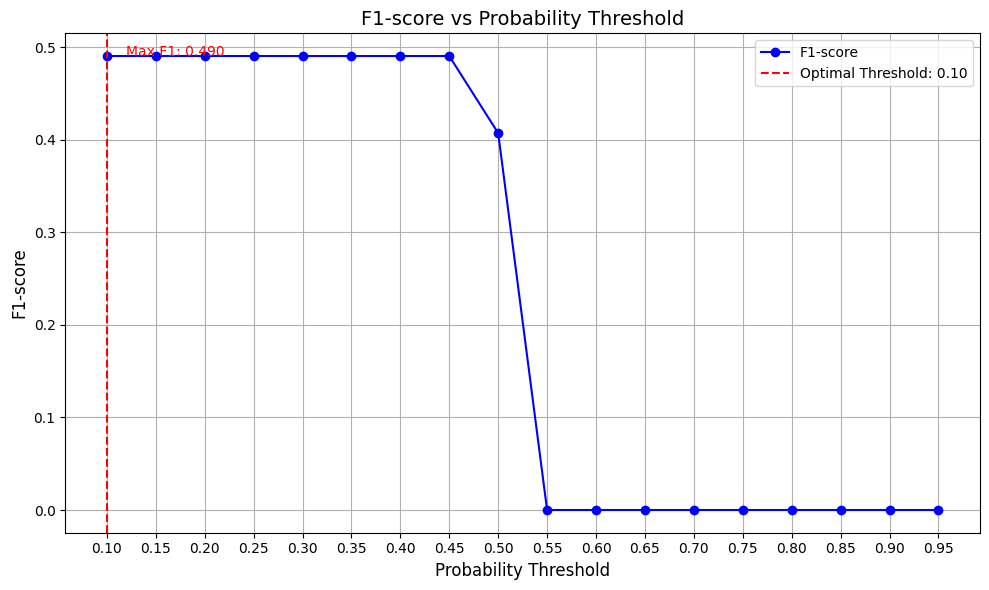

Оптимальный порог вероятности: 0.100
Максимальная F1-мера на тестовой выборке: 0.490
Классификационный отчет:
              precision    recall  f1-score   support

           0       1.00      0.00      0.00       424
           1       0.32      1.00      0.49       204

    accuracy                           0.32       628
   macro avg       0.66      0.50      0.25       628
weighted avg       0.78      0.32      0.16       628



In [21]:
# Предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_proba_pred = pd.Series(log_reg.predict_proba(X_test_poly)[:, 1])

# Инициализация списков для сохранения метрик
f1_scores = []

# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)

# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание класса по принципу: если вероятность > threshold, то отнести объект к классу 1, в противном случае — к классу 0
    y_test_pred_poly = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    
    # Рассчитываем метрики
    f1 = f1_score(y_test, y_test_pred_poly)

    # Добавляем результаты в списки
    f1_scores.append(f1)

# Определение оптимального порога вероятности
optimal_threshold = thresholds[f1_scores.index(max(f1_scores))]
optimal_f1 = max(f1_scores)

# Визуализация F1-меры при различных порогах вероятности
fig, ax = plt.subplots(figsize=(10, 6))  # Создаем фигуру и оси
ax.plot(thresholds, f1_scores, label='F1-score', color='blue', marker='o')

# Добавляем линию и текст для оптимального порога
ax.axvline(optimal_threshold, color='red', linestyle='--', label=f'Optimal Threshold: {optimal_threshold:.2f}')
ax.text(optimal_threshold + 0.02, optimal_f1, f"Max F1: {optimal_f1:.3f}", color='red')

# Подписи и оформление графика
ax.set_title('F1-score vs Probability Threshold', fontsize=14)
ax.set_xlabel('Probability Threshold', fontsize=12)
ax.set_ylabel('F1-score', fontsize=12)
ax.set_xticks(thresholds)
ax.legend()
ax.grid()

# Отображение графика
plt.tight_layout()
plt.show()

# Предсказание классов с оптимальным порогом вероятности
y_test_pred_optimal = y_test_proba_pred.apply(lambda x: 1 if x > optimal_threshold else 0)

# Расчет итоговой F1-метрики и классификационного отчета
final_f1 = f1_score(y_test, y_test_pred_optimal)
print(f"Оптимальный порог вероятности: {optimal_threshold:.3f}")
print(f"Максимальная F1-мера на тестовой выборке: {final_f1:.3f}")
print("Классификационный отчет:")
print(classification_report(y_test, y_test_pred_optimal, zero_division=1))

Оптимальный порог вероятности для модели логистической регрессии, обученной на полиномиальных признаках, составляет 0.100. При этом F1-мера на тестовой выборке составляет 0.49. Это может указывать на то, что модель имеет низкую точность для класса 0 (неотток), но довольно хорошую для класса 1 (отток). Однако, следует отметить, что результаты могли бы быть лучше, если увеличить порог вероятности.

## Практика: деревья решений и случайный лес

Мы продолжаем решать задачу прогнозирования оттока клиентов банка.

Ранее мы построили модель логистической регрессии, затем добавили в модель полиномиальные признаки и подобрали оптимальный порог вероятности для логистической регрессии.

> Теперь попробуем решить задачу с помощью деревьев решений и лесов.


> **Примечание №1.** Для выполнения дальнейших заданий необходимо совершить уже знакомые шаги предобработки с данными об оттоке клиентов банка, а именно:
* выделить данные, относящиеся к отделениям банка в Германии;
* избавиться от заведомо неинформативных признаков;
* расширить датасет путём добавления новых признаков;
* разделить выборку на тренировочную и тестовую со стратификацией.

> **Примечание №2.** Деревья решений — алгоритм, способный уловить нелинейные зависимости. Генерация полиномиальных признаков практически не имеет значения.
Также деревья решений не чувствительны к масштабу признаков. Масштабирование исходных данных не играет роли при построении деревьев решения.
Поэтому для решения задачи используйте обучающую (`X_train`, `y_train`) и тестовую (`X_test`, `y_test`) выборки без полиномиальных столбцов.


In [22]:
# Выборка только по немецкому филиалу
churn_data = churn_data[churn_data['Geography'] == 'Germany']

# Удаляем лишние неинформативные признаки
churn_data = churn_data.drop(['Geography', 'RowNumber', 'CustomerId', 'Surname'], axis=1)

# Расчет отношения баланса на счетах к предполагаемой заработной плате клиента
churn_data['BalanceSalaryRatio'] = churn_data['Balance'] / churn_data['EstimatedSalary']
# Расчет отношения времени пользования услугами банка к возрасту клиента
churn_data['TenureByAge'] = churn_data['Tenure'] / churn_data['Age']
# Расчет отношения кредитного рейтинга к возрасту клиента
churn_data['CreditScoreGivenAge'] = churn_data['CreditScore'] / churn_data['Age']

# Кодирование оставшегося категориального признака
churn_data = pd.get_dummies(churn_data)

# Основные статистические характеристики
display(churn_data.describe())

# Создаем матрицу признаков X и столбец с ответами y
X = churn_data.drop("Exited", axis=1)
y = churn_data["Exited"]

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge
count,1531.000000,1531.000000,1531.000000,1531.000000,1531.000000,1531.000000,1531.000000,1531.00000,1531.000000,1531.000000,1531.000000,1531.000000
mean,648.517962,39.860222,5.056826,119412.827694,1.525800,0.710647,0.499020,100377.94983,0.326584,12.518667,0.135274,17.387806
std,98.479872,10.471377,2.926111,26616.691003,0.616617,0.453610,0.500162,57905.64378,0.469117,274.053669,0.087660,5.277498
min,351.000000,18.000000,0.000000,32197.640000,1.000000,0.000000,0.000000,11.58000,0.000000,0.192582,0.000000,6.112676
25%,582.000000,32.500000,2.000000,103020.855000,1.000000,0.000000,0.000000,50246.47500,0.000000,0.791880,0.062500,13.688889
50%,647.000000,38.000000,5.000000,119127.460000,1.000000,1.000000,0.000000,101300.94000,0.000000,1.197220,0.128205,16.727273
75%,717.000000,45.000000,8.000000,136774.440000,2.000000,1.000000,1.000000,149314.49000,1.000000,2.420551,0.200000,20.753378
max,850.000000,84.000000,10.000000,206868.780000,4.000000,1.000000,1.000000,199970.74000,1.000000,10614.655440,0.500000,46.388889


In [23]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, 
    stratify=y, 
    random_state=0
)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))
display(churn_data.head())

Train shape: (1148, 13)
Test shape: (383, 13)


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge,Gender_Female,Gender_Male
6252,596,32,3,96709.07,2,0,0,41788.37,0,2.314258,0.093750,18.625000,False,True
4742,506,59,8,119152.10,2,1,1,170679.74,0,0.698103,0.135593,8.576271,False,True
5202,597,22,6,101528.61,1,1,0,70529.00,1,1.439530,0.272727,27.136364,True,False
439,464,42,3,85679.25,1,1,1,164104.74,0,0.522101,0.071429,11.047619,True,False
5653,687,41,2,154007.21,1,1,0,158408.23,0,0.972217,0.048780,16.756098,True,False


Импортируем необходимые для выполнения практики модули:

In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

Приступим! Выполните задания 8.1–8.4.

### Задание 8.1. (2 балла)

Обучите на тренировочной выборке дерево решений из библиотеки `sklearn` (`DecisionTreeClassifier`) с неограниченной максимальной глубиной дерева. В качестве критерия информативности используйте энтропию Шеннона, остальные параметры оставьте по умолчанию. 

Также позаботьтесь о воспроизводимости результатов, установив конкретное  значение `random_state` (например, число 42). 

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сделайте вывод, ответив на вопрос:
* Как вы считаете, является полученная модель переобученной или недообученной? Попробуйте дать обоснование, почему так происходит.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос, а также обоснование полученного результата.

- Задание выполнено верно, но не приведено обоснование полученного результата или обоснование является некорректным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [25]:
# Инициализация модели дерева решений с энтропией Шеннона
dt_model = DecisionTreeClassifier(
    criterion='entropy', 
    random_state=42,  # Воспроизводимость
    max_depth=None  # Без ограничения глубины
)

# Обучаем модель
dt_model.fit(X_train, y_train)

# Прогнозирование на тренировочной и тестовой выборках
y_train_pred = dt_model.predict(X_train)
y_test_pred = dt_model.predict(X_test)

# Расчёт F1-меры на тренировочной и тестовой выборках
train_f1 = f1_score(y_train, y_train_pred)
test_f1 = f1_score(y_test, y_test_pred)

# Вывод результатов
print(f"F1-мера на тренировочной выборке: {round(train_f1, 3)}")
print(f"F1-мера на тестовой выборке: {round(test_f1, 3)}")

F1-мера на тренировочной выборке: 1.0
F1-мера на тестовой выборке: 0.609


F1-мера на тренировочной выборке: 1.0 — это указывает на то, что модель идеально предсказывает классы для тренировочной выборки, не совершая ошибок. Это явный признак переобучения, так как модель слишком сильно подогнана под тренировочные данные.

F1-мера на тестовой выборке: 0.609 — значение метрики на тестовой выборке значительно ниже, чем на тренировочной. Это подтверждает, что модель плохо обобщает на новые данные, что также является характеристикой переобучения.

Поскольку дерево решений не ограничено по глубине (параметр max_depth=None), модель может построить дерево, которое идеально подгоняет данные, что приводит к переобучению. В случае с большими деревьями модель запоминает детали, которые специфичны для тренировочных данных, включая возможный шум или редкие случаи, что снижает её способность обобщать.

### Задание 8.2. (1 балл)

Давайте «подстрижём» наше дерево. 

Обучите на тренировочной выборке дерево решений из библиотеки `sklearn` (`DecisionTreeClassifier`) с максимальной глубиной 8. В качестве критерия информативности используйте энтропию Шеннона, минимальное число объектов в листе (количество объектов, при которых дерево прекратит делиться и образуется лист) — 10.

Также позаботьтесь о воспроизводимости результатов, установив конкретное значение `random_state` (например, число 42).

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сравните результат с полученными ранее. Сделайте вывод.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балла**): 
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [26]:
# Создаем и обучаем дерево решений
dt_model = DecisionTreeClassifier(
    criterion='entropy',       # Используем энтропию Шеннона
    max_depth=8,               # Ограничение максимальной глубины
    min_samples_leaf=10,       # Минимальное количество объектов в листе
    random_state=42            # Для воспроизводимости
)

# Обучение на тренировочной выборке
dt_model.fit(X_train, y_train)

# Предсказания
y_train_pred = dt_model.predict(X_train)
y_test_pred = dt_model.predict(X_test)

# Расчёт F1-меры на тренировочной и тестовой выборках
train_f1 = f1_score(y_train, y_train_pred)
test_f1 = f1_score(y_test, y_test_pred)

# Вывод результатов
print(f"F1-мера на тренировочной выборке: {round(train_f1, 3)}")
print(f"F1-мера на тестовой выборке: {round(test_f1, 3)}")

F1-мера на тренировочной выборке: 0.726
F1-мера на тестовой выборке: 0.627


Судя по полученным новым значениям, переобучение уменьшилось.

В предыдущей модели F1-мера на тренировочной выборке равнялась 1.0, что указывало на сильное переобучение.
В новой модели метрика на тренировочной выборке снизилась до 0.726, что говорит о лучшей обобщающей способности модели, также улучшилась тестовая метрика.

F1-мера на тестовой выборке увеличилась с 0.609 до 0.627, что свидетельствует о более качественном предсказании на новых данных. Ограничения нашей модели повысили ее устойчивость.
Уменьшение глубины дерева (до 8) и ограничение минимального числа объектов в листе (10) помогли модели избегать запоминания данных и лучше обобщать закономерности.
В итоге, модель с ограничениями глубины и минимального числа объектов подходит лучше для текущей задачи. Она показывает хорошую обобщающую способность, минимизируя переобучение.

### Задание 8.3. (1 балл)

Давайте воспользуемся случайным лесом. 

Постройте случайный лес (`RandomForestClassifier`) из 500 деревьев с максимальной глубиной 8. Критерий информативности — энтропия Шеннона, минимальное число объектов в листе (количество объектов, при которых дерево прекратит делиться и образуется лист) — 10.

Также позаботьтесь о воспроизводимости результатов, установив конкретное значение значение `random_state` (например, число 42).

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сравните качество одного дерева решений с качеством случайного леса на тестовой выборке. Смогли ли вы улучшить метрику?


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [27]:
# Создаем и обучаем дерево решений
dfc_model = RandomForestClassifier(
    n_estimators=500,          # Ограничение количества деревьев
    criterion='entropy',       # Используем энтропию Шеннона
    max_depth=8,               # Ограничение максимальной глубины
    min_samples_leaf=10,       # Минимальное количество объектов в листе
    random_state=42            # Для воспроизводимости
)

# Обучение на тренировочной выборке
dfc_model.fit(X_train, y_train)

# Предсказания
y_train_pred = dfc_model.predict(X_train)
y_test_pred = dfc_model.predict(X_test)

# Расчёт F1-меры на тренировочной и тестовой выборках
train_f1 = f1_score(y_train, y_train_pred)
test_f1 = f1_score(y_test, y_test_pred)

# Вывод результатов
print(f"F1-мера на тренировочной выборке: {round(train_f1, 3)}")
print(f"F1-мера на тестовой выборке: {round(test_f1, 3)}")

F1-мера на тренировочной выборке: 0.72
F1-мера на тестовой выборке: 0.667


Случайный лес показал результат лучше на тестовой выборке (F1-мера 0.667) по сравнению с деревом решений (F1-мера 0.627). Это свидетельствует о том, что случайный лес лучше справляется с обобщением данных и менее склонен к переобучению.

Дерево решений имеет F1-меру на тренировочной выборке выше (0.726), чем случайный лес (0.72), что говорит о его тенденции к переобучению на тренировочных данных.

Использование случайного леса улучшило метрику на тестовой выборке. Хотя разница на тренировочной выборке невелика, случайный лес лучше справляется с со своей задачей, что делает его более надежным для прогнозов на новых данных.

### Задание 8.4. (2 балла)

Мы на финишной прямой. 


Попробуйте подобрать значение порога вероятности, при котором наблюдается наибольшее значение целевой метрики на тестовой выборке. **Используйте ту модель (из рассмотренных ранее), которая показала наилучшее качество на тестовой выборке.**

В качестве порога вероятности используйте значения из следующего диапазона:

`thresholds = np.arange(0.1, 1, 0.05)`

Напомним алгоритм, как определить оптимальный порог вероятности:
* Предсказать вероятности оттока для каждого клиента из тестовой выборки.
* В цикле перебрать значения порогов вероятности threshold:
    * Сделать предсказание класса по принципу: если вероятность > threshold, то отнести объект к классу 1, в противном случае — к классу 0.
    * Рассчитать метрику и занести её в заранее созданный список. 

Для реализации алгоритма подбора вы можете воспользоваться шаблоном кода, приведённым ниже:

```python
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_proba_pred = pd.Series(model.predict_proba(X_test_poly)[:, 1])
# Инициализируем список, куда будем сохранять метрики.
scores = []
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)
# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание
    y_test_pred_poly = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    # Рассчитываем метрику
    score = # код для вычисления метрики
    # Добавляем результат в список
    scores.append(score)
```

Постройте график зависимости целевой метрики от порога вероятности. На основе построенного графика определите порог вероятности, которому соответствует наибольшее значение целевой метрики на тестовой выборке.

Сделайте предсказание классов с подобранным оптимальным порогом вероятности. Рассчитайте значение целевой метрики на тестовой выборке и сравните полученный результат с полученными ранее. 

Напишите небольшой вывод о проделанной работе, указав в нём, какая из рассмотренных нами моделей показала наилучший результат.

> **Примечание.** Помните о том, что в реальных задачах (а мы решали задачу на реальных данных) мы практически никогда не сможем получить значения метрик, близкие к 1. Если в задаче прогнозирования оттока ваша метрика превышает хотя бы значения 0.6-0.7, вашу модель уже можно считать хорошей и можно говорить о том, что она успешно справляется с задачей.

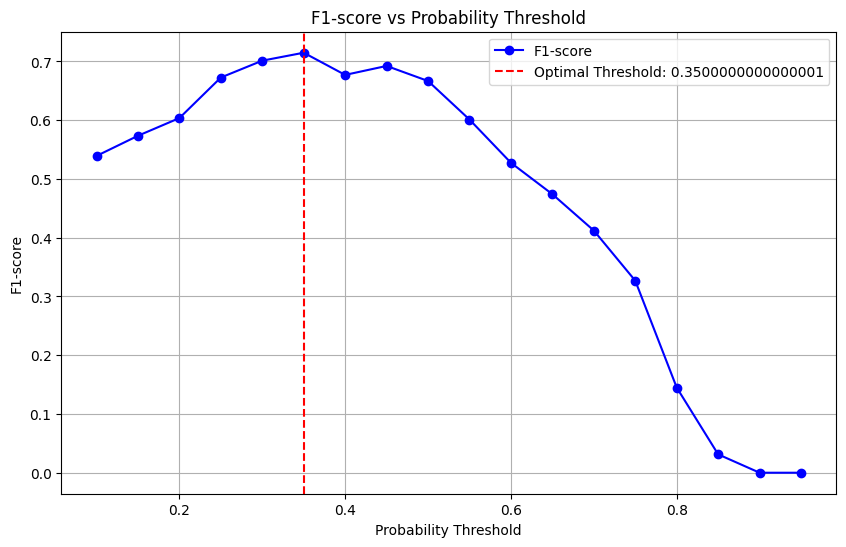

Оптимальный порог вероятности: 0.350
Максимальная F1-мера на тестовой выборке: 0.715
Классификационный отчет:
              precision    recall  f1-score   support

           0       0.89      0.79      0.84       258
           1       0.65      0.79      0.71       125

    accuracy                           0.79       383
   macro avg       0.77      0.79      0.78       383
weighted avg       0.81      0.79      0.80       383



In [28]:
# Предсказание вероятностей для тестовой выборки
y_test_proba_pred = pd.Series(dfc_model.predict_proba(X_test)[:, 1])  # RandomForestClassifier model

# Инициализация списка для F1-мер
f1_scores = []

# Задаём диапазон порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)

# Перебираем пороги
for threshold in thresholds:
    # Предсказание классов на основе порога
    y_test_pred = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    # Расчет F1-меры
    f1 = f1_score(y_test, y_test_pred)
    f1_scores.append(f1)

# Определение оптимального порога
optimal_threshold = thresholds[f1_scores.index(max(f1_scores))]
optimal_f1 = max(f1_scores)

# Построение графика зависимости F1 от порога вероятности
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1-score', marker='o', color='blue')
plt.axvline(optimal_threshold, color='red', linestyle='--', label=f'Optimal Threshold: {optimal_threshold}')
plt.title('F1-score vs Probability Threshold')
plt.xlabel('Probability Threshold')
plt.ylabel('F1-score')
plt.legend()
plt.grid()
plt.show()

# Предсказание классов с оптимальным порогом
y_test_pred_optimal = y_test_proba_pred.apply(lambda x: 1 if x > optimal_threshold else 0)

# Расчет F1-метрики и вывод классификационного отчета
final_f1 = f1_score(y_test, y_test_pred_optimal)
print(f"Оптимальный порог вероятности: {optimal_threshold:.3f}")
print(f"Максимальная F1-мера на тестовой выборке: {final_f1:.3f}")
print("Классификационный отчет:")
print(classification_report(y_test, y_test_pred_optimal, zero_division=1))

В рамках задачи был проведён подбор оптимального порога вероятности для модели RandomForestClassifier, чтобы максимизировать F1-меру. Результаты анализа показали, что:

- Оптимальный порог вероятности: 0.35. При данном пороге вероятность значения больше 0.35 относит объект к классу 1, иначе — к классу 0.
- Максимальная F1-мера: 0.715 на тестовой выборке. Это значение F1-метрики свидетельствует о сбалансированной точности и полноте для классов 0 и 1.

Модель RandomForestClassifier оказалась наиболее подходящей моделью для данной задачи, показав максимальное значение F1-меры 0.715 на тестовой выборке. Она обеспечивает хороший баланс между точностью и полнотой, а также демонстрирует высокую общую точность.

### Задание 8.5. (1 балл)

Наконец, финальная задача.

У нашего банка есть некоторый клиент, назовём его Василием. В базе данных банка хранятся следующие данные о Василии:

```python
{
    'CreditScore': [601.0],
    'Gender': ['Male'],
    'Age': [42.0],
    'Tenure': [1.0],
    'Balance': [98495.72],
    'NumOfProducts': [1.0],
    'HasCrCard': [1.0],
    'IsActiveMember': [0.0],
    'EstimatedSalary': [40014.76]
}
```

С помощью наилучшей модели спрогнозируйте вероятность того, что Василий откажется от услуг банка.

> **Примечание.** Учтите, что для предсказания необходимо преобразовать данные к тому формату, на котором обучалась модель, то есть:
* добавить признаки дополнительные признаки; 
* произвести кодирование категориальных признаков;
* произвести масштабирование признаков (если ваша модель обучалась на масштабированных данных) с помощью того же скейлера, который вы использовали при обучении модели;
* сгенерировать полиномиальные признаки.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * сформирован DataFrame на основе предоставленного словаря;
    * произведены преобразования данных, необходимые для работы модели;
    * предсказана вероятность оттока клиента (вероятность принадлежности к классу 1).

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [29]:
# Исходные данные о Василии
client_data = {
    'CreditScore': [601.0],
    'Gender': ['Male'],
    'Age': [42.0],
    'Tenure': [1.0],
    'Balance': [98495.72],
    'NumOfProducts': [1.0],
    'HasCrCard': [1.0],
    'IsActiveMember': [0.0],
    'EstimatedSalary': [40014.76]
}

# Преобразуем в DataFrame
client_df = pd.DataFrame(client_data)

# Шаг 1. Добавляем расчетные признаки
client_df['BalanceSalaryRatio'] = client_df['Balance'] / client_df['EstimatedSalary']
client_df['TenureByAge'] = client_df['Tenure'] / client_df['Age']
client_df['CreditScoreGivenAge'] = client_df['CreditScore'] / client_df['Age']

# Шаг 2. Кодируем категориальный признак Gender
client_df = pd.get_dummies(client_df, columns=['Gender'])

# Убедимся, что все признаки из обучающей выборки присутствуют
trained_features = X_train.columns

# Добавляем отсутствующие признаки с нулями и упорядочиваем
for feature in trained_features:
    if feature not in client_df.columns:
        client_df[feature] = 0
client_df = client_df[trained_features]

# Шаг 3. Прогнозирование вероятности
client_proba = dfc_model.predict_proba(client_df)[:, 1][0]

# Вывод вероятности
print(f"Вероятность того, что Василий откажется от услуг банка: {client_proba:.2%}")

Вероятность того, что Василий откажется от услуг банка: 38.54%
